In [33]:
import pandas as pd
import numpy as np
from PIL import Image
import math
import random
import librosa

from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchaudio
import torchaudio.transforms as T

device = torch.device("cuda:0")

In [4]:
from BCResNet import SubSpectralNorm, BroadcastedBlock, TransitionBlock,\
 BCResNet, MHAttKWS

In [ ]:
from kwt import PreNorm, PostNorm, FeedForward, Attention, Transformer,\
 KWT, kwt_from_name

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

### Looking at dataframes content  and audiofiles characteristics

In [ ]:
df_speech = pd.read_csv('./CleanSpeechTrain.csv')
df_speech

,filename
0,./CleanSpeech_training/clnsp1.wav
1,./CleanSpeech_training/clnsp10.wav
2,./CleanSpeech_training/clnsp100.wav
3,./CleanSpeech_training/clnsp101.wav
4,./CleanSpeech_training/clnsp102.wav
...,...
166,./CleanSpeech_training/clnsp249.wav
167,./CleanSpeech_training/clnsp25.wav
168,./CleanSpeech_training/clnsp250.wav
169,./CleanSpeech_training/clnsp251.wav


In [ ]:
df_noise = pd.read_csv('./NoiseTrain.csv')
df_noise

,filename
0,./Noise_training/noisy100_SNRdb_0.0.wav
1,./Noise_training/noisy100_SNRdb_10.0.wav
2,./Noise_training/noisy100_SNRdb_20.0.wav
3,./Noise_training/noisy100_SNRdb_30.0.wav
4,./Noise_training/noisy101_SNRdb_0.0.wav
...,...
679,./Noise_training/noisy253_SNRdb_30.0.wav
680,./Noise_training/noisy254_SNRdb_0.0.wav
681,./Noise_training/noisy254_SNRdb_10.0.wav
682,./Noise_training/noisy254_SNRdb_20.0.wav


In [ ]:
sample_wav_file = df_speech['filename'][0]
waveform, sample_rate = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate}')

Shape of the waveform: torch.Size([1, 52320])

Sampling rate of the audio file: 16000


In [ ]:
sample_wav_file = df_noise['filename'][0]
waveform1, sample_rate1 = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform1.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate1}')

Shape of the waveform: torch.Size([1, 53292])

Sampling rate of the audio file: 16000


### Function to make and plot MelSpectrogram

In [ ]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto"):
    fig, axs = plt.subplots(1, 1)

    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")

    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)

    fig.colorbar(im, ax=axs)
    plt.savefig("output.jpg")
    plt.show()

In [ ]:
sample_rate = 16000
n_fft=480
hop_length=160
n_mels=40
# n_fft = 1024
# hop_length = 512
# n_mels = 128

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   center=True,
                                   pad_mode="reflect",
                                   power=2.0,
                                   norm='slaney',
                                   n_mels=n_mels,
                                   mel_scale="htk")

### MelSpectrogram of a clean speech

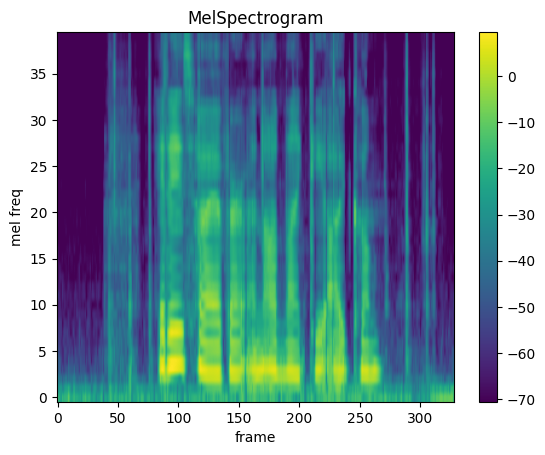

In [ ]:
melspec = mel_spectrogram(waveform)
img = plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')
img

## MelSpec graph w/o unnecessary info

In [ ]:
def plot_mel_spec_clean(spec, aspect="auto"):
    # TODO: log?
    im = plt.imshow(spec,
                    origin="lower", aspect=aspect)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible (False)

    plt.savefig("output.png", bbox_inches='tight',
                pad_inches=0, transparent=True)

### Checking dimensions placement

In [ ]:
img = Image.open(r'./output.png')
print(np.array(img).shape)

(369, 496, 4)


In [ ]:
def prepare_image(path):
    size = (369, 369)
    img = Image.open(path).convert('RGB').resize(size)

    np_img = np.array(img, dtype='uint8')
    img_tens = np.transpose(np_img, (2, 1, 0))/255
    tens = torch.from_numpy(img_tens)

    return tens

In [ ]:
l = prepare_image(r'./output.png')

In [ ]:
l.shape

torch.Size([3, 369, 369])

### MelSpectrogram of a noisy speech

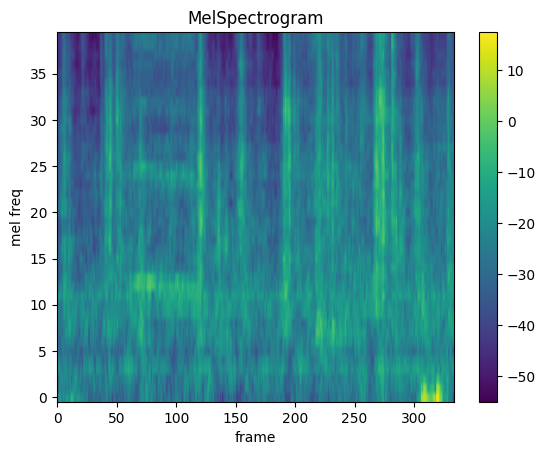

In [ ]:
melspec1 = mel_spectrogram(waveform1)
img = plot_spectrogram(melspec1[0], title="MelSpectrogram", ylabel='mel freq')
img

Log MelSpectrogram of the clean speech

In [ ]:
# get mel spectrogram
eps_value=1e-6
melsp = torch.log(mel_spectrogram(waveform) + eps_value)
melsp

tensor([[[ -4.1986,  -4.0354,  -5.2442,  ...,  -1.9673,  -1.7585,  -3.6979],
         [ -6.3077,  -6.8335,  -6.2604,  ...,  -4.1482,  -4.0420,  -3.8671],
         [ -7.8476,  -8.7118,  -9.4211,  ...,  -8.8175, -10.5497,  -8.2389],
         ...,
         [-13.7201, -13.7916, -13.7915,  ..., -13.7863, -13.7740, -13.7475],
         [-13.5821, -13.7602, -13.7773,  ..., -13.7575, -13.7479, -13.7046],
         [-13.5318, -13.7684, -13.7897,  ..., -13.7821, -13.7829, -13.7143]]])

In [ ]:
melsp.size(2)

328

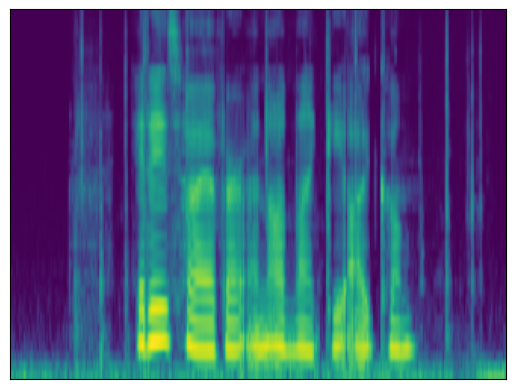

In [ ]:
# plot mel spectrogram
img = plot_mel_spec_clean(melsp[0])
img

In [ ]:
mel_nframes = 300
n_mels = 40
image = torch.full((1, n_mels, mel_nframes), melsp.min())
image

tensor([[[-13.8106, -13.8106, -13.8106,  ..., -13.8106, -13.8106, -13.8106],
         [-13.8106, -13.8106, -13.8106,  ..., -13.8106, -13.8106, -13.8106],
         [-13.8106, -13.8106, -13.8106,  ..., -13.8106, -13.8106, -13.8106],
         ...,
         [-13.8106, -13.8106, -13.8106,  ..., -13.8106, -13.8106, -13.8106],
         [-13.8106, -13.8106, -13.8106,  ..., -13.8106, -13.8106, -13.8106],
         [-13.8106, -13.8106, -13.8106,  ..., -13.8106, -13.8106, -13.8106]]])

In [ ]:
image[0, :, :mel_nframes] = melsp[:, :, :mel_nframes]
image

tensor([[[ -4.1986,  -4.0354,  -5.2442,  ...,  -6.7982,  -6.2669,  -5.8116],
         [ -6.3077,  -6.8335,  -6.2604,  ...,  -7.7632,  -8.8600,  -7.2539],
         [ -7.8476,  -8.7118,  -9.4211,  ...,  -8.5834,  -9.3843,  -8.5757],
         ...,
         [-13.7201, -13.7916, -13.7915,  ..., -13.7595, -13.7632, -13.7658],
         [-13.5821, -13.7602, -13.7773,  ..., -13.7662, -13.7694, -13.7665],
         [-13.5318, -13.7684, -13.7897,  ..., -13.7760, -13.7820, -13.7755]]])

In [ ]:
image.size()

torch.Size([1, 40, 300])

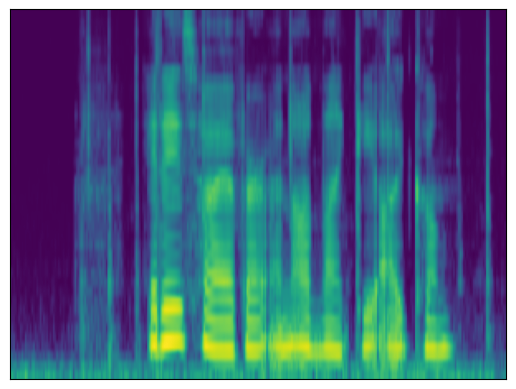

In [ ]:
# get mel spectrogram cropped to the 300 n-frames
im = plot_mel_spec_clean(image[0])
im

In [ ]:
a = image/255
a

tensor([[[-0.0165, -0.0158, -0.0206,  ..., -0.0267, -0.0246, -0.0228],
         [-0.0247, -0.0268, -0.0246,  ..., -0.0304, -0.0347, -0.0284],
         [-0.0308, -0.0342, -0.0369,  ..., -0.0337, -0.0368, -0.0336],
         ...,
         [-0.0538, -0.0541, -0.0541,  ..., -0.0540, -0.0540, -0.0540],
         [-0.0533, -0.0540, -0.0540,  ..., -0.0540, -0.0540, -0.0540],
         [-0.0531, -0.0540, -0.0541,  ..., -0.0540, -0.0540, -0.0540]]])

Log MelSpectrogram of the noise

In [ ]:
melsp1 = torch.log(mel_spectrogram(waveform1)+eps_value)

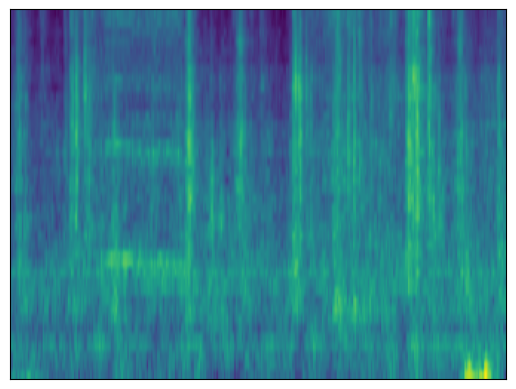

In [ ]:
img1 = plot_mel_spec_clean(melsp1[0])
img1

In [ ]:
image1 = torch.full((1, n_mels, mel_nframes), melsp1.median())
image1

tensor([[[-5.5944, -5.5944, -5.5944,  ..., -5.5944, -5.5944, -5.5944],
         [-5.5944, -5.5944, -5.5944,  ..., -5.5944, -5.5944, -5.5944],
         [-5.5944, -5.5944, -5.5944,  ..., -5.5944, -5.5944, -5.5944],
         ...,
         [-5.5944, -5.5944, -5.5944,  ..., -5.5944, -5.5944, -5.5944],
         [-5.5944, -5.5944, -5.5944,  ..., -5.5944, -5.5944, -5.5944],
         [-5.5944, -5.5944, -5.5944,  ..., -5.5944, -5.5944, -5.5944]]])

In [ ]:
image1[0, :, :mel_nframes] = melsp1[:, :, :mel_nframes]
image1.size()

torch.Size([1, 40, 300])

Log MelSpectrogram of the noisy speech

In [ ]:
# combining clean and noisy audios
mainmel = image+image1
mainmel

tensor([[[ -9.9811,  -8.4552,  -8.8329,  ..., -12.6464, -12.9435, -12.6028],
         [-13.2849, -14.1942, -10.7669,  ..., -13.0268, -12.9618, -12.8956],
         [-15.5555, -15.3865, -14.1493,  ..., -12.3245, -13.3557, -13.0855],
         ...,
         [-24.3502, -23.8488, -23.7484,  ..., -23.4530, -22.7793, -22.4823],
         [-24.1442, -23.9025, -23.5322,  ..., -22.7023, -21.7024, -22.3250],
         [-23.9828, -23.7254, -23.9835,  ..., -22.6733, -20.8898, -21.6779]]])

In [ ]:
mainmel.size()

torch.Size([1, 40, 300])

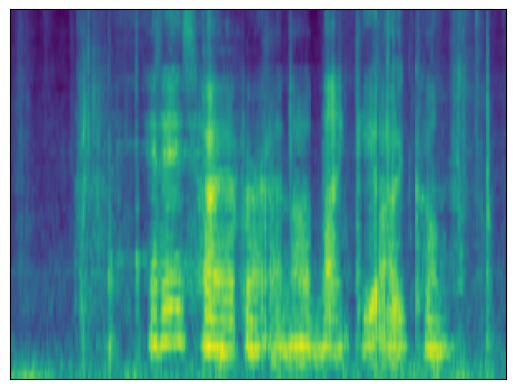

In [ ]:
mainimg = plot_mel_spec_clean(mainmel[0])
mainimg

### Custom Dataset

In [6]:
class AudioDataset(Dataset):

    def __init__(self, path_speech, path_noise, eps_value=1e-6,\
                 mel_nframes=300, sample_rate=16000, n_fft=480,\
                 hop_length=160, n_mels=40):

        self.speech = pd.read_csv(path_speech)
        self.noise = pd.read_csv(path_noise)
        self.eps_value = eps_value
        self.mel_nframes = mel_nframes
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mel_spectrogram = T.MelSpectrogram(sample_rate=self.sample_rate,
                                                n_fft=self.n_fft,
                                                hop_length=self.hop_length,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm='slaney',
                                                n_mels=self.n_mels)

    def __len__(self):

        return len(self.speech)

    def get_same_shape(self, waveform):

        melsp = torch.log(self.mel_spectrogram(waveform) + self.eps_value)

        has_mel_nframes = melsp.size(2) if melsp.size(2) < self.mel_nframes\
         else self.mel_nframes

        image_tens = torch.full((1, self.n_mels, self.mel_nframes), melsp.min())
        image_tens[0, :, :has_mel_nframes] = melsp[:, :, :has_mel_nframes]

        return image_tens/255

    def load_item(self, df, idx):

        sample_wav_file = df['filename'][idx]
        wave, _ = torchaudio.load(sample_wav_file)
        wave = wave.float()

        wave_melsp = self.get_same_shape(wave)

        return wave_melsp

    def __getitem__(self, idx):

        wave_speech = self.load_item(self.speech, idx)

        luck = random.random()
        if luck > 0.5:
            wave_noise = self.load_item(self.noise, idx)

            wave_out = wave_speech + wave_noise
            label = 1

        else:
            wave_out = wave_speech
            label = 0

        return wave_out, torch.tensor(label)

In [7]:
audio_dataset_train = AudioDataset('./CleanSpeechTrain.csv',
                                   './NoiseTrain.csv')

audio_dataset_val = AudioDataset('./CleanSpeechVal.csv',
                                   './NoiseVal.csv')

audio_dataset_test = AudioDataset('./CleanSpeechTest.csv',
                                   './NoiseTest.csv')

In [ ]:
idx = 0
audio_train, class_label_train = audio_dataset_train[0]
audio_val, class_label_val = audio_dataset_train[0]
audio_test, class_label_test = audio_dataset_train[0]

In [ ]:
class_label_train

tensor(1)

In [ ]:
audio_train

tensor([[[-0.0391, -0.0332, -0.0346,  ..., -0.0496, -0.0508, -0.0494],
         [-0.0521, -0.0557, -0.0422,  ..., -0.0511, -0.0508, -0.0506],
         [-0.0610, -0.0603, -0.0555,  ..., -0.0483, -0.0524, -0.0513],
         ...,
         [-0.0955, -0.0935, -0.0931,  ..., -0.0920, -0.0893, -0.0882],
         [-0.0947, -0.0937, -0.0923,  ..., -0.0890, -0.0851, -0.0875],
         [-0.0941, -0.0930, -0.0941,  ..., -0.0889, -0.0819, -0.0850]]])

In [ ]:
audio_train.size()

torch.Size([1, 40, 300])

### Sampler and Data Loader

In [8]:
train_loader = DataLoader(dataset=audio_dataset_train,
                          batch_size=50, drop_last=True)

val_loader = DataLoader(dataset=audio_dataset_val,
                        batch_size=50, drop_last=True)

test_loader = DataLoader(dataset=audio_dataset_test,
                         batch_size=50, drop_last=True)

In [ ]:
for i, sample in enumerate(test_loader):
    print(i)
    print(sample)

Train function

In [122]:
def train(model, train_loader, val_loader, loss,
          optimizer, scheduler, num_epochs):

    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):

        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch+1}',
                  leave=True) as pb:

            for i, (x, y) in enumerate(train_loader):

                x_gpu = x.to(device)
                y_gpu = y.to(device)

                prediction = model(x_gpu)
                value, indices = torch.max(prediction, 1)

                loss_value = loss(value, y_gpu.float())
                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()

                correct_samples += torch.sum(indices==y_gpu)
                total_samples += y.size(0)
                loss_accum += loss_value

                pb.update()
                pb.set_description( f'Epoch {epoch+1}:'
                                    f' Average loss: {loss_value:.3f},'
                                    f' Train accuracy:'
                                    f' {correct_samples/total_samples:.2f},'
                                    )

            ave_loss = loss_accum / epoch+1
            train_accuracy = float(correct_samples) / total_samples
            val_accuracy = compute_accuracy(model, val_loader)

            scheduler.step()

            loss_history.append(float(ave_loss))
            train_history.append(train_accuracy)
            val_history.append(val_accuracy)

            pb.set_description( f'Epoch {epoch+1}:'
                                f' Average loss: {ave_loss:.3f},'
                                f' Train accuracy: {train_accuracy:.2f},'
                                f' Val accuracy: {val_accuracy:.2f}'
                                )

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):

    model.eval()

    correct_samples = 0
    total_samples = 0

    for i, (x, y) in enumerate(loader):

        x_gpu = x.to(device)
        y_gpu = y.to(device)

        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices==y_gpu)
        total_samples += y_gpu.size(0)

    return float(correct_samples) / total_samples

MHAttKWS

In [123]:
model_mhat = MHAttKWS(num_classes=2)
model_mhat.type(torch.FloatTensor)
model_mhat.to(device)

MHAttKWS(
  (cnn_extractor): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(10, 1, kernel_size=(5, 1), stride=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (rnn): LSTM(1, 128, num_layers=2, batch_first=True, bidirectional=True)
  (q_emb): Linear(in_features=256, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [124]:
loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)

optimizer = optim.SGD(model_mhat.parameters(),
                       lr=1e-2,
                       weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [125]:
loss_history, train_history, val_history = train(model_mhat, train_loader,
                                                 val_loader, loss,
                                                 optimizer, scheduler,
                                                 num_epochs=5)

Epoch 1: Average loss: inf, Train accuracy: 0.49, Val accuracy: 0.48: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]
Epoch 2: Average loss: 3.105, Train accuracy: 0.47, Val accuracy: 0.56: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]
Epoch 3: Average loss: 2.040, Train accuracy: 0.52, Val accuracy: 0.52: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]
Epoch 4: Average loss: 1.690, Train accuracy: 0.54, Val accuracy: 0.50: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]
Epoch 5: Average loss: 1.523, Train accuracy: 0.50, Val accuracy: 0.38: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


KWT

In [ ]:
model = KWT()

TypeError: ignored

BCResNet

In [ ]:
model_bcrn = BCResNet(scale=2, num_labels=2)

In [ ]:
loss = nn.BCELoss()
optimizer = optim.Adam(model_bcrn.parameters(),
                       lr=1e-4,
                       weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

In [ ]:
loss_history, train_history = train(model_bcrn, train_loader, loss,
                                    optimizer, scheduler, num_epochs=10)

torch.Size([1, 1, 128, 300])


RuntimeError: ignored

In [ ]:
# shape '[1, 40, 12, 300]' is invalid for input of size 153600
# CONV2D
# 1 - batch_size
# 40 - channels
# 12 - hight
# 300 - width

### Trying for Fully connected NN

In [ ]:
t_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(38400, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
    )
t_model.type(torch.FloatTensor)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=38400, out_features=256, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=128, out_features=2, bias=True)
  (6): Softmax(dim=1)
)

In [ ]:
def train_model(model, train_loader, loss, optimizer, scheduler, num_epochs):

    loss_history = []
    train_history = []

    loss_accum = 0
    correct_samples = 0
    total_samples = 0

    for epoch in range(num_epochs):
#         model.train()

        ms = MelSpecToTensor('./cleanSpeech.xlsx', './noises.xlsx')
        x, y = ms.get_mel_spec()
#         y = torch.tensor([y])
        prediction = model(x)
#         print(prediction.size(), y.size())
#         print('pred', prediction)

        loss_value = loss(prediction, y)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        _, indices = torch.max(prediction, 1)
#         print('indicex', indices)
        correct_samples += torch.sum(indices == y)
        total_samples += 1
        loss_accum += loss_value

        ave_loss = loss_accum / total_samples
        train_accuracy = float(correct_samples) / total_samples

        scheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        print(f'Average loss: {ave_loss}, Train accuracy: {train_accuracy}')

    return loss_history, train_history

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model.parameters(),
                       lr=1e-4,
                       weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

In [ ]:
loss_history, train_history = train_model(t_model, loss,
                                          optimizer, scheduler, 10)

Average loss: 0.7267991304397583, Train accuracy: 0.0
Average loss: 0.694682240486145, Train accuracy: 0.5
Average loss: 0.7014099955558777, Train accuracy: 0.3333333333333333
Average loss: 0.7461764216423035, Train accuracy: 0.25
Average loss: 0.7285192012786865, Train accuracy: 0.4
Average loss: 0.7163393497467041, Train accuracy: 0.5
Average loss: 0.7113810181617737, Train accuracy: 0.5714285714285714
Average loss: 0.7136791348457336, Train accuracy: 0.5
Average loss: 0.7151896953582764, Train accuracy: 0.4444444444444444
Average loss: 0.7171934247016907, Train accuracy: 0.4
